In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES']=str(0)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import pandas as pd
from probml_utils import latexify, savefig
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

%config InlineBackend.figure_format = 'retina'

In [3]:
%env LATEXIFY=1
%env FIG_DIR=figures/

env: LATEXIFY=1
env: FIG_DIR=figures/


In [4]:
def mass_to_std_factor(mass=0.95):
    rv = norm(0.0, 1.0)
    std_factor = rv.ppf((1.0 + mass) / 2)
    return std_factor


def plot_mass_normal(mass=0.95, mean=0.0, scale=1.0):
    rv = norm(mean, scale)
    std_factor = mass_to_std_factor(mass)
    x = np.linspace(rv.ppf(1e-10), rv.ppf(1 - 1e-10), 500)
    y = rv.pdf(x)
    plt.plot(x, y)
    idx = np.where((x < mean + std_factor * scale) & (x > mean - std_factor * scale))[0]
    plt.fill_between(x[idx], y[idx], 0, color="k", alpha=0.2)
    plt.ylim((0, y.max() + 0.1))
    plt.title(f"Mass: {mass:0.2f}, std_factor:{std_factor:0.2f}")

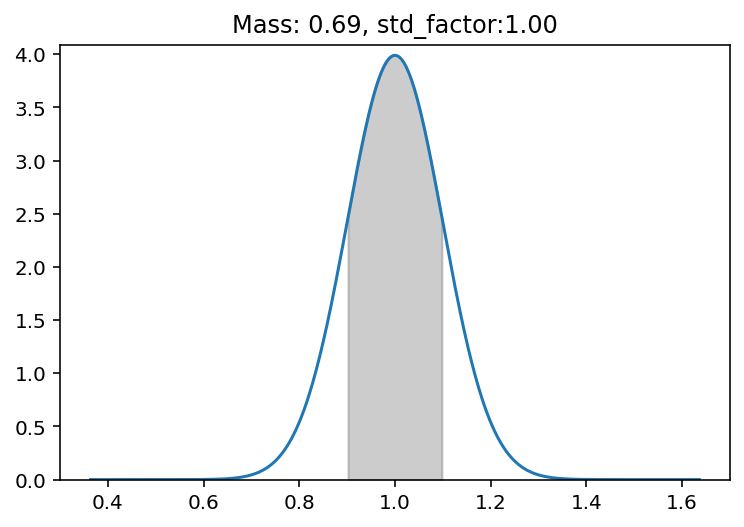

In [5]:
plot_mass_normal(mass=0.685, mean=1, scale=0.1)

In [6]:
X = np.linspace(start=0, stop=10, num=200).reshape(-1, 1)
f = np.squeeze(X * np.sin(X))
y = f + 2 * np.random.randn(len(X))

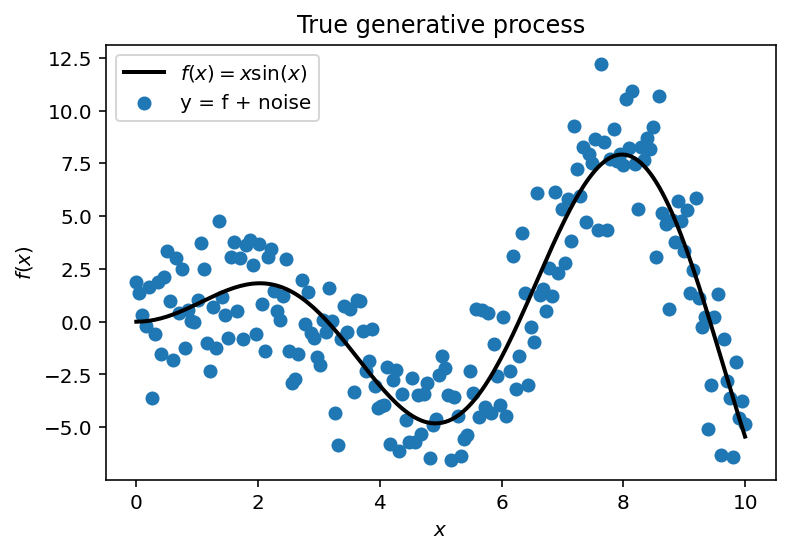

In [7]:
plt.plot(X, f, label=r"$f(x) = x \sin(x)$", lw = 2, color='k')
plt.scatter(X, y, label=r"y = f + noise")


plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process")

In [8]:
rng = np.random.RandomState(5)
training_indices = rng.choice(np.arange(y.size), size=20, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

calibration_indices = rng.choice(np.arange(y.size), size=10, replace=False)
X_cal, y_cal = X[calibration_indices], y[calibration_indices]

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(
    kernel=kernel, n_restarts_optimizer=9, alpha=0.9
)

In [10]:
def plot_find_p(ax, X, y, regressor, mass=0.95,ori_mass=0.95, plot=False):
    mean_prediction, std_prediction = regressor.predict(X, return_std=True)
    std_factor = mass_to_std_factor(mass)
    idx = np.where(
        (y.flatten() < mean_prediction + std_factor * std_prediction)
        & (y.flatten() > mean_prediction - std_factor * std_prediction)
    )[0]

    p_hat = len(idx) / len(X)

    if plot:

        ax.plot(X, y, "--",label=r"$f(x) = x \sin(x)$")
        ax.scatter(X_train, y_train, label="Observations", s=5)
        ax.fill_between(
            X.ravel(),
            mean_prediction - std_factor * std_prediction,
            mean_prediction + std_factor * std_prediction,
            alpha=0.2,
            label=rf"{100*ori_mass:0.2f}% CI, $\mu \pm {std_factor:0.2f}\sigma$",
        )
        ax.plot(X, mean_prediction, label="Mean prediction")
        ax.scatter(X[idx], y[idx], label="Within", color="C1", s=8)

        # ax.legend(
        #     bbox_to_anchor=(1.04, 1),
        #     loc="upper left",
        # )
        # ax.set_xlabel("$x$")
        # plt.title(rf"p = {mass}, $\hat{{p}}$ = {p_hat:0.2f}")
        ax.set_title(f"\% of points within CI \n{p_hat*100:0.2f}\%")
    return (mass, p_hat)

In [11]:
def plot_calibration(X_cal, y_cal, regressor, plot=False):
    mean_prediction, std_prediction = regressor.predict(X_cal, return_std=True)
    out = {}
    for mass in np.linspace(1e-10, 1-1e-10, 1000):
        out[mass] = plot_find_p(None,X_cal, y_cal, regressor, mass)[1]
    df = pd.Series(out).to_frame()
    df.index.name = 'p'
    df.columns = ['p_hat']
    if plot:
        df.plot(legend=None, label=False)
        plt.plot([0, 1], [0, 1], label="Ideal")
        plt.legend()
        plt.xlabel("p")
        plt.ylabel(r"$\hat{p}$")
    return df

In [12]:
from sklearn.isotonic import IsotonicRegression

series_cal = plot_calibration(X_cal, y_cal, gaussian_process)
calibrator = IsotonicRegression()

# Fit a model going from \hat{p} to p(true) (which is the line with 45 degree slope)
calibrator.fit(series_cal.values, series_cal.index)

IsotonicRegression()

In [13]:
gaussian_process.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0.9, kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=9)

In [14]:
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

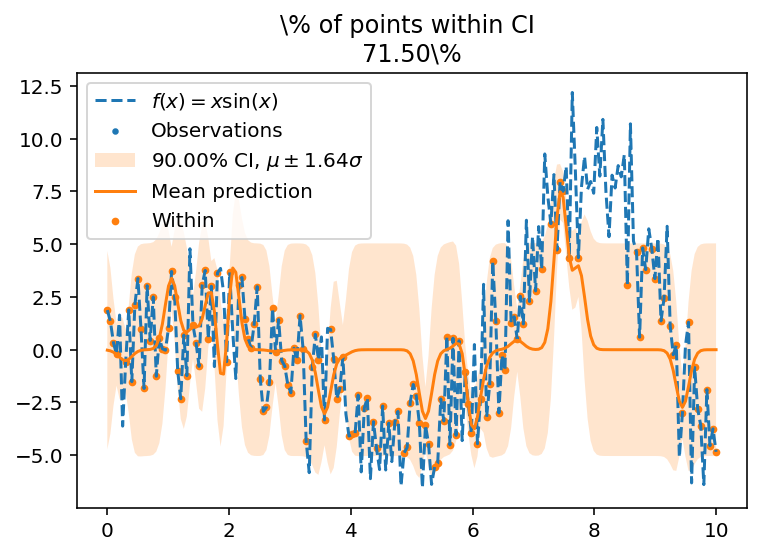

In [15]:
fig, ax = plt.subplots(1)
plot_find_p(ax, X, y, gaussian_process, mass=0.9, ori_mass=0.9, plot=True)
ax.legend()

In [16]:
series = plot_calibration(X, y, gaussian_process)

In [17]:
series_cal = plot_calibration(X_cal, y_cal, gaussian_process)
calibrator = IsotonicRegression()

# Fit a model going from \hat{p} to p(true) (which is the line with 45 degree slope)
calibrator.fit(series_cal.values, series_cal.index)

IsotonicRegression()

In [18]:
calibrator.predict([0.9])

array([0.97397397])

In [19]:
# plot_find_p(None, X, y, gaussian_process, calibrator.predict([0.9])[0],0.9, plot=True)

In [20]:
new_p = calibrator.predict(series.index)
new_p_hat = []
for mass in new_p:
    new_p_hat.append(plot_find_p(None,X, y, gaussian_process, mass)[1])

In [21]:
new_p_hat = np.array(new_p_hat)

In [22]:
latexify(fig_height=2, fig_width=3.5)

saving image to figures/callibration_fill_between_latexified.pdf
Figure size: [3.5 2. ]


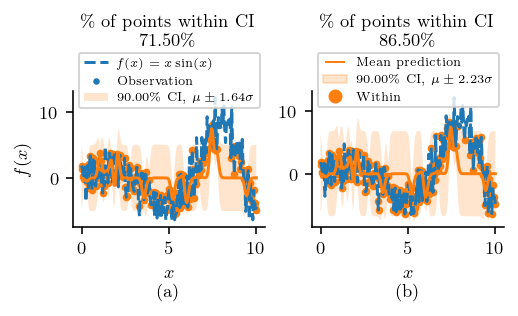

In [23]:
fig, ax = plt.subplots(1,2)
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = +23

plot_find_p(ax[0], X, y, gaussian_process, mass=0.9, ori_mass=0.9, plot=True)
ax[0].set_ylabel("$f(x)$")
ax[0].set_xlabel("$x$\n(a)")
h = ax[0].legend([
                    "$f(x) = x \sin(x)$", 
                    "Observation", 
                    f"{100*0.9:0.2f}\% CI, $\mu \pm {mass_to_std_factor(0.9):0.2f}\sigma$"
                ],
                loc="upper left", 
                bbox_to_anchor=(0,1.33),
                fontsize=6)


plot_find_p(ax[1], X, y, gaussian_process, calibrator.predict([0.9])[0], 0.9, plot=True)
red_patch = mpatches.Patch(color='C1', alpha=0.2, 
        label=f"{100*0.9:0.2f}\% CI, $\mu \pm {mass_to_std_factor(calibrator.predict([0.9])[0]):0.2f}\sigma$")
nine = mlines.Line2D([], [], color='C1', marker='o', ls='', label='Within')
line = mlines.Line2D([], [], color='C1', marker="_", ls='', label='Mean prediction', markersize=10)
h = ax[1].legend(handles=[line,red_patch, nine], loc="upper left", bbox_to_anchor=(0,1.33), fontsize=6)
ax[1].set_xlabel("$x$\n(b)")

sns.despine()
savefig("callibration_fill_between")

In [24]:
latexify(fig_height=1.5, fig_width=3)

saving image to figures/calibration_regression_plot_latexified.pdf
Figure size: [3.  1.5]


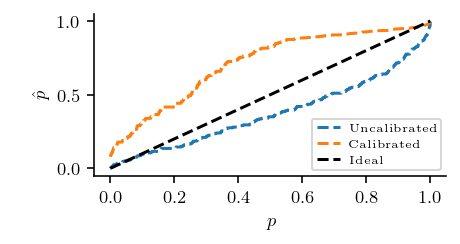

In [25]:
fig, ax = plt.subplots(1)
ax.plot(series.index, series.values, "--", label='Uncalibrated')
ax.plot(series.index, calibrator.predict(series.values), "--", label='Calibrated')

ax.plot([0, 1], [0, 1],"--", color="black", label="Ideal")
# plt.gca().set_aspect("equal")
ax.set_xlabel("$p$")
ax.set_ylabel("\n$\hat{p}$")
ax.legend(loc="lower right", fontsize=5.7)
sns.despine()
savefig("calibration_regression_plot")

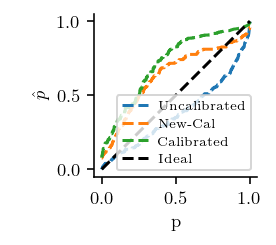

In [26]:
plt.plot(series.index, series.values, "--", label='Uncalibrated')
plt.plot(series.index, new_p_hat, "--", label='New-Cal')
plt.plot(series.index, calibrator.predict(series.values), "--", label='Calibrated')

plt.plot([0, 1], [0, 1],"--", color="black", label="Ideal")
plt.gca().set_aspect("equal")
plt.legend(fontsize=6.4)
sns.despine()
plt.xlabel("p")
plt.ylabel("\n$\hat{p}$")
sns.despine()
# savefig("callibration_regression", tight_bbox=True)

In [ ]:
plot_find_p(X, y, gaussian_process, mass=0.9, ori_mass=0.9,plot=True)

(0.983983983887187, 0.945)

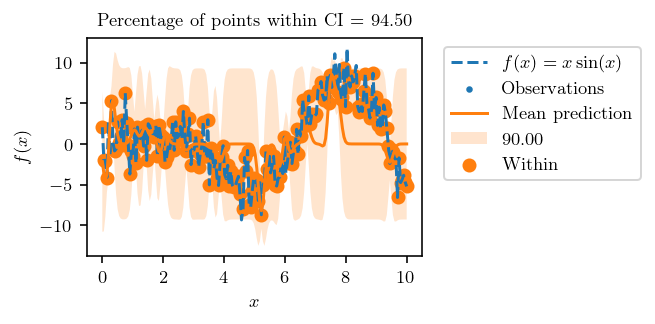

In [ ]:
plot_find_p(X, y, gaussian_process, calibrator.predict([0.9])[0],0.9, plot=True)